In [9]:
pip install tensorboardX

  Using cached tensorboardX-2.6.2.2-py2.py3-none-any.whl.metadata (5.8 kB)
Using cached tensorboardX-2.6.2.2-py2.py3-none-any.whl (101 kB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Importing necessary libraries for logging, file handling, and system operations
import logging  # Provides a flexible framework for emitting log messages from Python programs.
import os  # Provides a way of using operating system-dependent functionality, such as reading or writing to the file system.
import shutil  # Used for high-level file operations, such as copying or removing files and directories.
import sys  # Provides access to some variables used or maintained by the Python interpreter and to functions that interact with the interpreter.
import tempfile  # Used to create temporary files and directories.
import random  # Implements pseudo-random number generators for various distributions.
import numpy as np  # Fundamental package for scientific computing with Python, providing support for large, multi-dimensional arrays and matrices.
from tqdm import trange  # Provides a progress bar for loops, making it easier to track long-running tasks.
import matplotlib.pyplot as plt  # A plotting library used for creating static, animated, and interactive visualizations in Python.
import torch  # PyTorch, an open-source machine learning library based on the Torch library, used for applications such as computer vision and natural language processing.
from skimage.util import random_noise  # A function to add random noise of various types to an image.

# Importing functions and classes from the MONAI library, a deep learning framework specialized for healthcare imaging
from monai.apps import download_and_extract  # Utility to download and extract files, particularly useful for datasets.
from monai.config import print_config  # Prints the current configuration of MONAI, including the environment, installed packages, and versions.
from monai.data import CacheDataset, DataLoader  # CacheDataset caches data and is useful for datasets that fit in memory. DataLoader is used to load the data in batches.
from monai.networks.nets import AutoEncoder  # Importing an AutoEncoder model, which is a type of neural network used for unsupervised learning, particularly for dimensionality reduction.
from monai.transforms import (  # Importing various transformations to be applied to the data.
    EnsureChannelFirstD,  # Ensures the channel dimension is first in the data tensor.
    Compose,  # Allows the chaining of multiple transformations to be applied sequentially.
    LoadImageD,  # Loads images from a file.
    RandFlipD,  # Randomly flips the image along a specified axis.
    RandRotateD,  # Randomly rotates the image within a specified angle range.
    RandZoomD,  # Randomly zooms in or out of the image within a specified range.
    ScaleIntensityD,  # Scales the intensity of the image to a specified range.
    EnsureTypeD,  # Ensures the output is of a specific data type.
    Lambda,  # Allows for custom transformations using a lambda function.
    AddChannelD
)
from monai.utils import set_determinism  # Sets the seed for random number generators to ensure reproducibility.
import math
import warnings
from typing import List

from torch import nn as nn
from torch.optim import Adam, Optimizer
from torch.optim.lr_scheduler import LambdaLR, _LRScheduler
import os
import random
import glob
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter
# Print the current MONAI configuration
print_config()
from pre_processing_py import HandScanDataset2, transform, validation_transform, train_df, valid_df, training_data_dir, display_images
from research_contributions.DAE.BTCV_Finetune import main_for_ngc



MONAI version: 0.8.0
Numpy version: 1.24.3
Pytorch version: 2.1.0.post100
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.20.0
Pillow version: 10.2.0
Tensorboard version: 2.17.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.15.2a0
tqdm version: 4.65.0
lmdb version: 1.4.1
psutil version: 6.0.0
pandas version: 2.0.3
einops version: 0.8.0
transformers version: 4.32.1
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [2]:
# Set up basic logging configuration to output log messages to the console (stdout).
# The logging level is set to INFO, meaning all messages at this level and above
# (INFO, WARNING, ERROR, CRITICAL) will be displayed.
logging.basicConfig(stream=sys.stdout, level=logging.INFO)


# Set deterministic behavior for reproducibility. This is important in experiments where
# you want to ensure that the results are the same every time the code is run. 
# The seed value is set to 0, which will be used to initialize the random number generator.
set_determinism(0)

# Determine the device to run the computations on. If a CUDA-capable GPU is available,
# the device will be set to "cuda" (meaning GPU); otherwise, it will fall back to "cpu".
# This allows the code to take advantage of GPU acceleration if possible.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
import matplotlib.pyplot as plt
import torch

def plot_ims(ims, shape=None, figsize=(10, 10), titles=None):
    shape = (1, len(ims)) if shape is None else shape
    plt.subplots(*shape, figsize=figsize)
    for i, im in enumerate(ims):
        plt.subplot(*shape, i + 1)
        
        # Convert numpy array to a compatible data type if needed
        if isinstance(im, np.ndarray):
            im = im.astype(np.float32)  # Convert to a supported type like float32
            im = torch.from_numpy(im)
        
        # Squeeze the image if it's a tensor
        if isinstance(im, torch.Tensor):
            im = torch.squeeze(im)
        
        plt.imshow(im, cmap="gray")
        
        if titles is not None:
            plt.title(titles[i])
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()


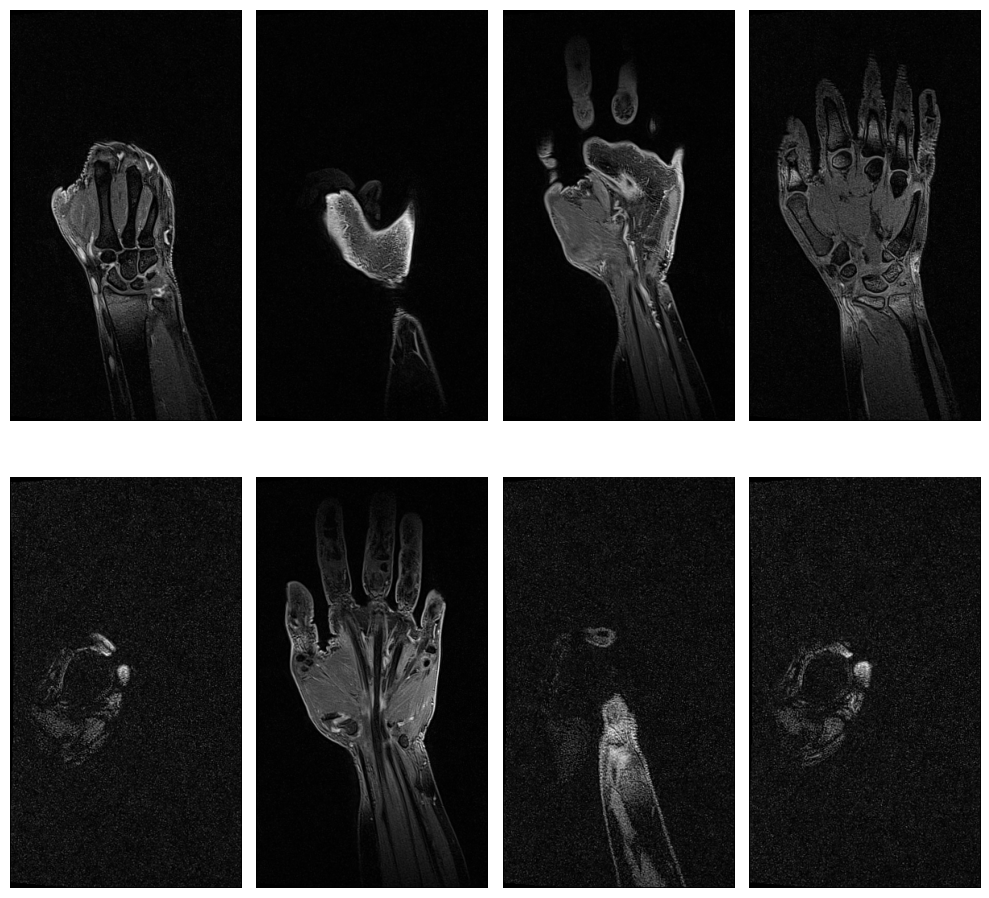

In [4]:
# Define a function to load DICOM images from a directory
def load_dicom_images(directory):
    dicom_files = []
    for image_path in glob.glob(os.path.join(directory, '*')):
        if os.path.isfile(image_path):  # Check if the path is a file (not a directory)
            try:
                dicom_file = pydicom.dcmread(image_path)
                dicom_files.append(dicom_file)
            except Exception as e:
                print(f"Error reading {image_path}: {e}")
    return dicom_files

# Define a function to extract pixel data from DICOM files
def extract_pixel_data(dicom_files):
    images = []
    for dicom_data in dicom_files:
        if hasattr(dicom_data, 'pixel_array'):  # Check if pixel data is present
            image = dicom_data.pixel_array
            images.append(image)
    return images

# Directory containing the images
data_dir = '/Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/CCP_28/9730895c1e/t1_vibe_we'  # Replace with the path to your DICOM files

# Load DICOM images from the directory
dicom_files = load_dicom_images(data_dir)

# Extract pixel data from the loaded DICOM files
images = extract_pixel_data(dicom_files)

# Check if there are any images loaded
if images:
    # Select random images
    rand_indices = np.random.choice(len(images), 8, replace=False)

    # Get the images corresponding to the random indices
    rand_images = [images[i] for i in rand_indices]
    
    # Visualize selected images
    plot_ims(rand_images, shape=(2, 4))
else:
    print(f"No images found in directory: {data_dir}")


In [5]:
'''
# Define a custom transformation using MONAI's Lambda transform.
# The transformation applies two types of noise to the image: Gaussian noise and Salt & Pepper noise.
# It creates a dictionary with three keys: "orig" (original image), "gaus" (image with Gaussian noise),
# and "s&p" (image with Salt & Pepper noise).
NoiseLambda = Lambda(
    lambda d: {
        "orig": d["im"],  # Original image
        "gaus": torch.tensor(random_noise(d["im"], mode="gaussian"), dtype=torch.float32),  # Gaussian noise
        "s&p": torch.tensor(random_noise(d["im"], mode="s&p", salt_vs_pepper=0.1)),  # Salt & Pepper noise
    }
)

# Define the set of transformations to apply to the training data.
train_transforms = Compose(
    [
        LoadImageD(keys=["im"]),  # Load the image from file
        EnsureChannelFirstD(keys=["im"]),  # Ensure the image has the channel dimension first (e.g., [C, H, W])
        ScaleIntensityD(keys=["im"]),  # Scale the intensity of the image to a specific range (default 0 to 1)
        RandRotateD(keys=["im"], range_x=np.pi / 12, prob=0.5, keep_size=True),  # Randomly rotate the image
        RandFlipD(keys=["im"], spatial_axis=0, prob=0.5),  # Randomly flip the image along the specified axis
        RandZoomD(keys=["im"], min_zoom=0.9, max_zoom=1.1, prob=0.5),  # Randomly zoom in/out on the image
        EnsureTypeD(keys=["im"]),  # Ensure the image is a PyTorch tensor with appropriate data type
        NoiseLambda,  # Apply the custom noise transformation
    ]
)

# Define the set of transformations to apply to the test data.
test_transforms = Compose(
    [
        LoadImageD(keys=["im"]),  # Load the image from file
        EnsureChannelFirstD(keys=["im"]),  # Ensure the image has the channel dimension first
        ScaleIntensityD(keys=["im"]),  # Scale the intensity of the image to a specific range
        EnsureTypeD(keys=["im"]),  # Ensure the image is a PyTorch tensor with appropriate data type
        NoiseLambda,  # Apply the custom noise transformation
    ]
)
'''

'\n# Define a custom transformation using MONAI\'s Lambda transform.\n# The transformation applies two types of noise to the image: Gaussian noise and Salt & Pepper noise.\n# It creates a dictionary with three keys: "orig" (original image), "gaus" (image with Gaussian noise),\n# and "s&p" (image with Salt & Pepper noise).\nNoiseLambda = Lambda(\n    lambda d: {\n        "orig": d["im"],  # Original image\n        "gaus": torch.tensor(random_noise(d["im"], mode="gaussian"), dtype=torch.float32),  # Gaussian noise\n        "s&p": torch.tensor(random_noise(d["im"], mode="s&p", salt_vs_pepper=0.1)),  # Salt & Pepper noise\n    }\n)\n\n# Define the set of transformations to apply to the training data.\ntrain_transforms = Compose(\n    [\n        LoadImageD(keys=["im"]),  # Load the image from file\n        EnsureChannelFirstD(keys=["im"]),  # Ensure the image has the channel dimension first (e.g., [C, H, W])\n        ScaleIntensityD(keys=["im"]),  # Scale the intensity of the image to a spe

In [6]:
'''def add_noise_transform(data):
    image = data["im"]
    # Store the original image
    data["orig"] = image

    # Apply Gaussian noise
    gaussian_noise = torch.tensor(random_noise(image.numpy(), mode="gaussian"), dtype=torch.float32)
    data["gaus"] = gaussian_noise

    # Apply Salt & Pepper noise
    sp_noise = torch.tensor(random_noise(image.numpy(), mode="s&p", salt_vs_pepper=0.1), dtype=torch.float32)
    data["s&p"] = sp_noise

    # Optionally, replace the "im" key if further transforms depend on this key
    data["im"] = image  # or one of the noise-augmented versions if desired

    return data


NoiseLambda = Lambda(add_noise_transform)'''
NoiseLambda = Lambda(
    lambda d: {
        "orig": d["im"],
        "gaus": torch.tensor(random_noise(d["im"], mode="gaussian"), dtype=torch.float32),
        "s&p": torch.tensor(random_noise(d["im"], mode="s&p", salt_vs_pepper=0.1)),
    }
)

train_transforms = Compose(
    [
        AddChannelD(keys=["im"]),
        ScaleIntensityD(keys=["im"]),
        RandRotateD(keys=["im"], range_x=np.pi / 12, prob=0.5, keep_size=True),
        RandFlipD(keys=["im"], spatial_axis=0, prob=0.5),
        RandZoomD(keys=["im"], min_zoom=0.9, max_zoom=1.1, prob=0.5),
        EnsureTypeD(keys=["im"]),
        NoiseLambda,
    ]
)

test_transforms = Compose(
    [
        AddChannelD(keys=["im"]),
        ScaleIntensityD(keys=["im"]),
        EnsureTypeD(keys=["im"]),
        NoiseLambda,
    ]
)


In [7]:
batch_size = 1
num_workers = 0



# Select a few subjects (e.g., the first three subjects)
train_subset_df = train_df.iloc[:1]
# Initialize the dataset with the selected subjects
train_ds = HandScanDataset2(labels_df=train_subset_df, data_dir=training_data_dir, transform=train_transforms)
# Create a data loader for testing
#train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

# Select a few subjects (e.g., the first three subjects)
valid_subset_df = valid_df.iloc[:1]
# Initialize the dataset with the selected subjects
train_dataset = HandScanDataset2(labels_df=valid_subset_df, data_dir=training_data_dir, transform=test_transforms)
# Create a data loader for testing
#test_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [4]:

python main_for_ngc.py --data_dir=/Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/t1_vibe_we_hand_subset/ --feature_size=48 --pos_embed='perceptron' --roi_x=384 --roi_y=512 --roi_z=2 --use_checkpoint --batch_size=1 --max_epochs=1 --save_checkpoint --model_name swin --logdir /Users/eleanorbolton/Library/CloudStorage/OneDrive-UniversityofLeeds/"Masters - 23-24"/Project/results --optim_lr 8e-4 --val_every 5 --set_determ True --seed 120


SyntaxError: invalid syntax (1293751438.py, line 1)

In [8]:
# Get image original and its degraded versions
def get_single_im(ds):
    loader = torch.utils.data.DataLoader(train_ds, batch_size=1, num_workers=0, shuffle=True)
    itera = iter(loader)
    return next(itera)


In [9]:
data = get_single_im(train_ds)
print(data[0].shape)
plot_ims([data["orig"], data["gaus"], data["s&p"]], titles=["orig", "Gaussian", "s&p"])


KeyError: "'im' key not found in the transformed data"